In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import glob
import cv2

import os
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print(files[3])
#Format of the files: age_gender_datetime
print("Total samples:",size)

Using TensorFlow backend.


26_0_1_20170114031743417.jpg.chip.jpg
Total samples: 23708


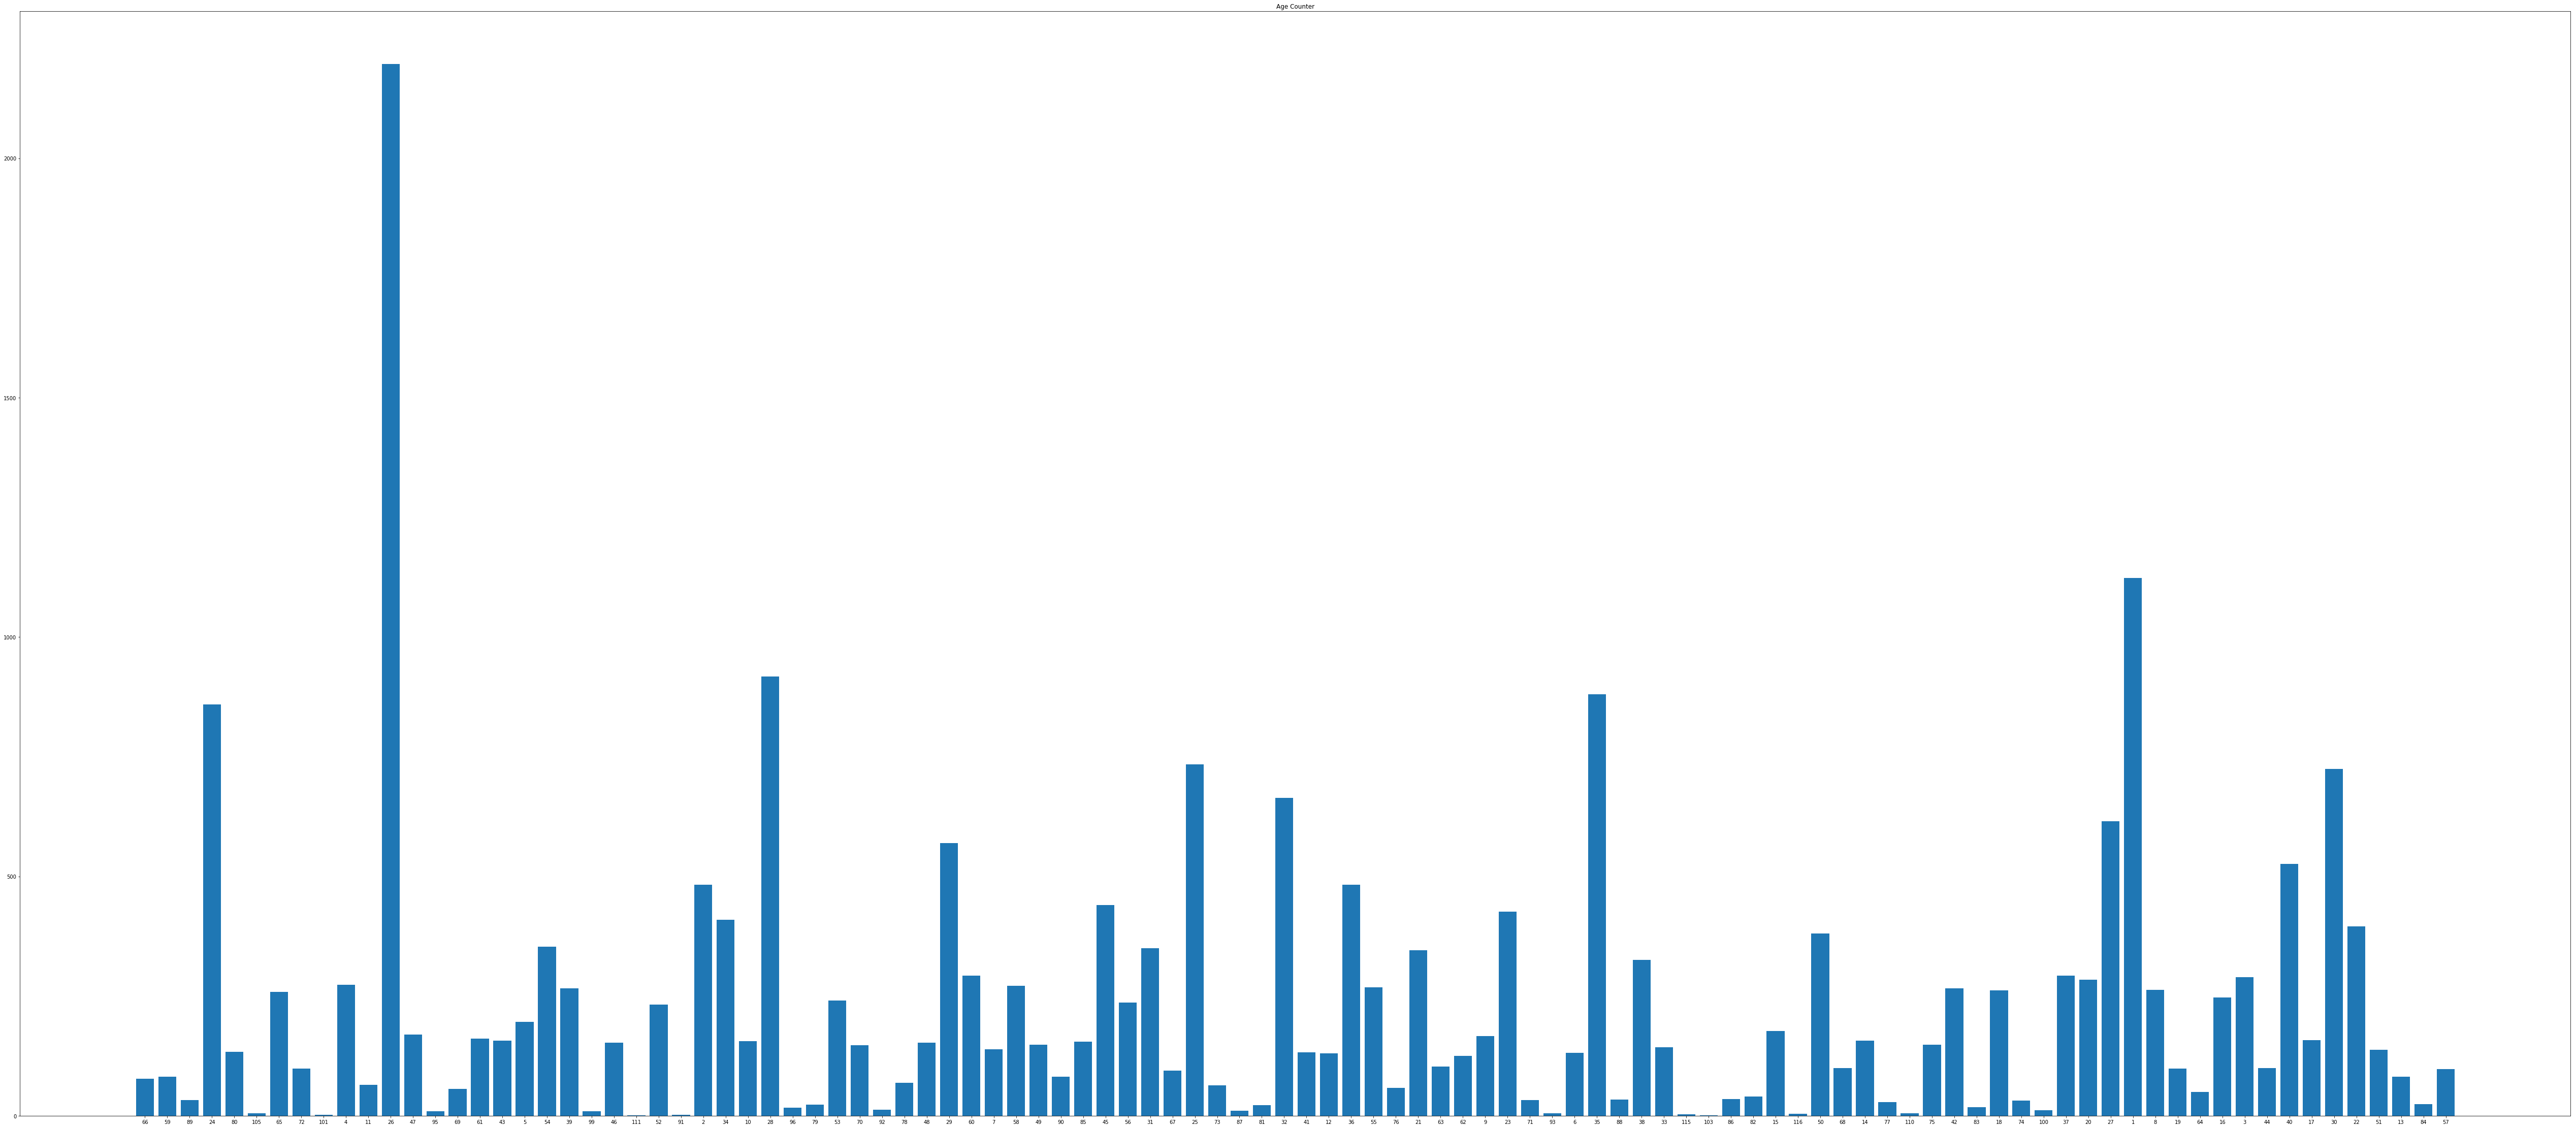

Max value: 99
Min value: 1


In [2]:
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )
    
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.figure(figsize=(90, 40))
plt.bar(x_ages,y_ages)
plt.title("Age Counter") 
plt.show()
print("Max value:",max(ages))
print("Min value:",min(ages))

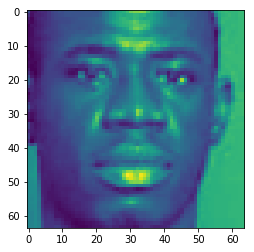

Gender: Male & Age: 26


In [3]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4 #unknown
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"
    
def display(img):
    plt.imshow(img[:,:,0])
    plt.show()
    
idx = 3
sample = images[idx]
display(sample)
print("Gender:",get_gender(genders[idx]),"& Age:",ages[idx])
#print("Gender:",genders[idx],"Age:",ages[idx])

In [4]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
print("Shape of the images:",sample.shape)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle = True)
print("Training images numbers:",x_train.shape[0])
print("Testing images numbers:",x_test.shape[0])

Shape of the images: (64, 64, 1)
Training images numbers: 18966
Testing images numbers: 4742


In [5]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

model.summary()

h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),
              epochs = 100, batch_size=128, shuffle = True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 60, 60, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 30, 30, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

dict_keys(['val_loss', 'val_dense_4_loss', 'val_dense_10_loss', 'val_dense_4_accuracy', 'val_dense_10_accuracy', 'loss', 'dense_4_loss', 'dense_10_loss', 'dense_4_accuracy', 'dense_10_accuracy'])


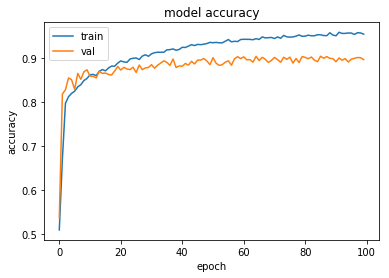

val accuracy: 88.21%


In [6]:
model.save('data.h')
history = h
print(history.history.keys())

plt.plot(history.history['dense_10_accuracy'])
plt.plot(history.history['val_dense_10_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

val_acc = np.mean(history.history['val_dense_10_accuracy'])
print("%s: %.2f%%" % ('val accuracy',(val_acc*100)))

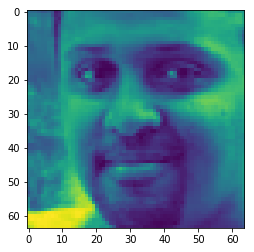

Actual Gender: Male Age: 28
Predicted Gender: Male Predicted Age: 19-30


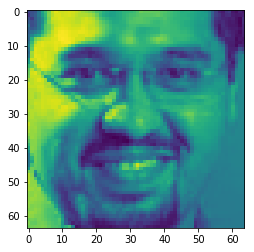

Actual Gender: Male Age: 26
Predicted Gender: Male Predicted Age: 31-80


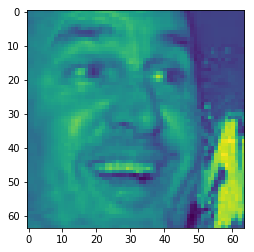

Actual Gender: Male Age: 50
Predicted Gender: Male Predicted Age: 31-80


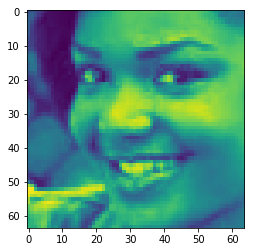

Actual Gender: Female Age: 22
Predicted Gender: Female Predicted Age: 19-30


In [7]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4 #unknown

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Predicted Gender:",gender,"Predicted Age:",age)

indexes = [4,55,666,7777]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)